# Monte Carlo Interactions

Here, we write a simple Monte Carlo to calculate diffusion of a single argon atom in argon gas, taking the origin as the position of the atom at time t=0.  We assume the gas is at standard temperature and pressure (ie. one mole is 22.7 liters at 100 kPa and 273 K), and throw the energy of gas molecules according to the Maxwell Boltzmann distribution (below).  The mean free path for argon is 6.2e-6 cm at 273 K.  We treat the atoms as "hard spheres" with radius 3.67e-8 cm and calculate the collisions in the center of mass. For hard spheres the angle of incidence=angle of reflection, where the angle is measured between the velocity and the line from the center of the sphere to the point of impact.   

From Wikipedia, we find Maxwell Boltmann distribution is defined as:
Assuming the system of interest contains a large number of particles, the fraction of the particles within an infinitesimal element of three-dimensional velocity space, ${\displaystyle d^{3}v},$ centered on a velocity vector of magnitude ${\displaystyle v}$, is ${\displaystyle f(v)d^{3}v}$, in which

$${\displaystyle f(v)~\mathrm {d} ^{3}v=\left({\frac {m}{2\pi kT}}\right)^{3/2}\,e^{-{\frac {mv^{2}}{2kT}}}~\mathrm {d} ^{3}v,}$$
where ${\displaystyle m} $ is the particle mass and ${\displaystyle kT}$ is the product of Boltzmann's constant and thermodynamic temperature.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import time

#Constants
m = 6.63352088e-26  #Mass of Ar in kg
T = 273  #Tempertaure in K
k = 1.38064852e-23  #Boltzmann's constant in m^2 kg s^-2 K^-2
r = 3.67e-10  #Radius of Ar atoms in m
mfp = 6.2e-8  #Mean free path in m
twokt = 2*k*T

Integrating the Maxwell-Boltzmann distribution over the solid angle yields a probability distribution of speeds:

$${\displaystyle f(v)~\mathrm{d}v=\left({\frac {m}{2\pi kT}}\right)^{3/2}4\pi v^2e^{-{\frac {mv^{2}}{2kT}}}~\mathrm {d}v,}$$

We can draw from this distribution by sampling $U \in [0,1]$ from a uniform distribution and solving

$$\int_0^v f(x) \mathrm{d}x = U\int_0^\infty f(x) \mathrm{d}x.$$

$$\int_0^v f(x) \mathrm{d}x = \mathrm{erf}\left(\left(\frac{m}{2kT}\right)^{\frac12}v\right) - \left(\frac{2m}{\pi kT}\right)^{\frac12}e^{-{\frac{mv^{2}}{2kT}}}$$

$$\int_0^\infty f(x) \mathrm{d}x = 1$$

$$\implies U = \mathrm{erf}\left(\left(\frac{m}{2kT}\right)^{\frac12}v\right) - \left(\frac{2m}{\pi kT}\right)^{\frac12}e^{-{\frac{mv^{2}}{2kT}}}$$

To make solving for $v$ for a given $U$ fast, we solve it for set points of $v\in [0,2000]$ initially, and then use an interpolation whenever we need to do it later.

In [2]:
from scipy.special import erf
from scipy.interpolate import interp1d

#Function for computing integral of Maxwell-Boltzmann distribution
G = lambda v: erf(np.sqrt(m/twokt)*v) - np.sqrt(4*m/(np.pi*twokt))*v*np.exp(-m*v**2/twokt)

vvals = np.linspace(0,2000,2000)
Uvals = G(vvals)

#Create an interpolation of the inverse function
interp = interp1d(Uvals, vvals, kind='cubic')

def drawVFromBoltzmann(n=1):
    '''
    Draw a random speed from the Maxwell-Boltzmann distribution
    '''
    U = np.random.rand() if n == 1 else np.random.rand(n)
    return interp(U)

In [5]:
def randDirection():
    '''
    Return a 3D unit vector in a random direction, i.e. a random point on a 2-sphere.
    '''
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)
    theta = np.arccos(costheta)
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def diffuse(nsteps=int(1e12), maxtime=7200):
    '''
    Monte carlo for simulation the diffusion of an Ar atom in Ar gas
    '''
    
    #Initial conditions
    x_0 = np.array([0,0,0])
    t_0 = 0
    v_0 = drawVFromBoltzmann()
    v_dir = randDirection()

    #Lists of position and time at end of step and velocity of step
    t = [t_0]
    x = [x_0]
    v = [v_0]

    t_start = time.time()
    for step in range(nsteps):
        '''
        Take a step of length mean free path in that direction
        Simulate a collision to compute a new velocity of the argon atom    
        '''
        
        #Compute the new position after the step and the time
        x.append(x[step] + v_dir*mfp)
        t.append(t[step] + mfp/v[-1])

        #Choose a random direction and velocity for the colliding particle
        collide_pt = randDirection()  #Direction of collision - unit vector pointing from center of main particle to collision pt on its surface
        collider_v_dir = randDirection()
        collider_v = drawVFromBoltzmann()
        #The colliding particle needs to be moving in such a way that it will actually collide with the main Ar atom
        while np.dot(v[-1]*v_dir, collide_pt) <= np.dot(collider_v*collider_v_dir, collide_pt):
            collide_pt = randDirection()
            collider_v_dir = randDirection()
            collider_v = drawVFromBoltzmann()
        
        #The new velocity after elastic collision with another Ar atom
        #From the initial velocity of the main particle, we subtract off the component in the direction of the colliding particle
        #and add the component of the colliding particles velocity in the direction of the main particle
        v_new = v_dir*v[-1] - np.dot(v_dir*v[-1], collide_pt)*collide_pt + np.dot(collider_v_dir*collider_v, collide_pt)*collide_pt
        v.append(norm(v_new))
        v_dir = v_new/norm(v_new)
        
        #Stop computation if the if maxtime is reached
        if time.time() - t_start > maxtime:
            nsteps = step
            print('Max allowed computation time reached.')
            break
            
    x = np.array(x)
    t = np.array(t)
    v = np.array(v)
    
    return x, v, t, time.time() - t_start, nsteps

x, v, t, t_elapsed, nsteps = diffuse(1000000)

print('Time to simulate %d collisions: %.2f seconds' % (nsteps, t_elapsed)) 

avg_cols_per_sec = nsteps/t[-1]
print('Average number of collisions per second: %.4e' % avg_cols_per_sec)

Time to simulate 1000000 collisions: 298.51 seconds
Average number of collisions per second: 4.8146e+09


Text(0.5, 1.0, 'Distance of the Ar atom from the origin over time for 1000000 steps')

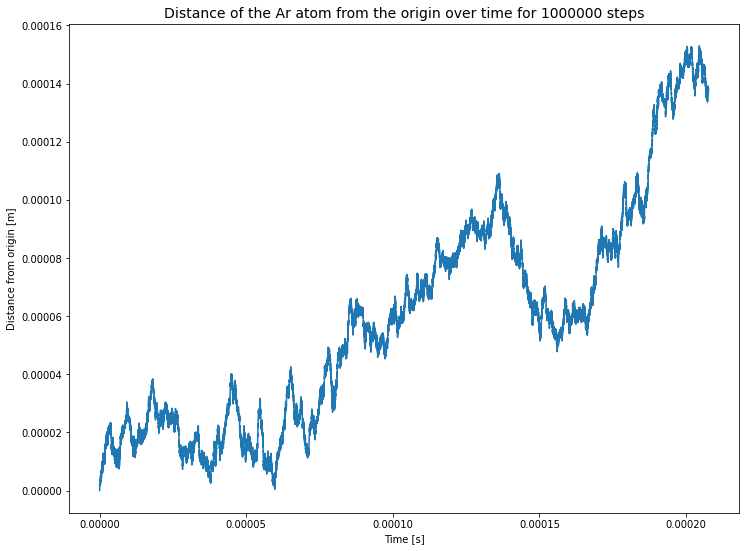

In [10]:
#Define functions to take the norm and dot product batchwise to avoid for loops
dot_batch = lambda v1, v2: np.sum(v1*v2, axis=1)
norm_sq_batch = lambda v: dot_batch(v,v)
norm_batch = lambda v: np.sqrt(norm_sq_batch(v))

dist_from_origin = norm_batch(x)

#Plot the distance from the origin as a function of time
plt.figure(figsize=(12,9))
plt.plot(t, dist_from_origin)
plt.ylabel('Distance from origin [m]')
plt.xlabel('Time [s]')
plt.title('Distance of the Ar atom from the origin over time for %d steps' % nsteps, fontsize=14)

(-2e-21, 4e-20)

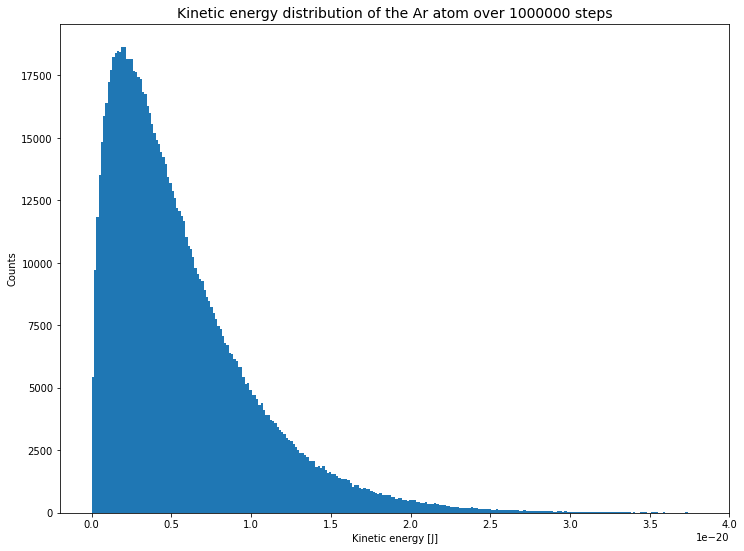

In [11]:
KE = 0.5*m*v**2

#Plot the kinetic energy distribution of the particle
plt.figure(figsize=(12,9))
plt.hist(KE, bins=400)
plt.xlabel('Kinetic energy [J]')
plt.ylabel('Counts')
plt.title('Kinetic energy distribution of the Ar atom over %d steps' % nsteps, fontsize=14)
plt.xlim(-0.2e-20, 4e-20)

In [471]:
#Run the computation for 3 hours
maxtime=3*60*60
x, v, t, t_elapsed, nsteps = diffuse(maxtime=maxtime)
print('Number of collisions in %.2f seconds: %d' % (t_elapsed, nsteps))

Max allowed computation time reached.
Number of collisions in 11357.42 seconds: 48091411


Average number of collisions per second: 4.8182e+09


(-2e-21, 5e-20)

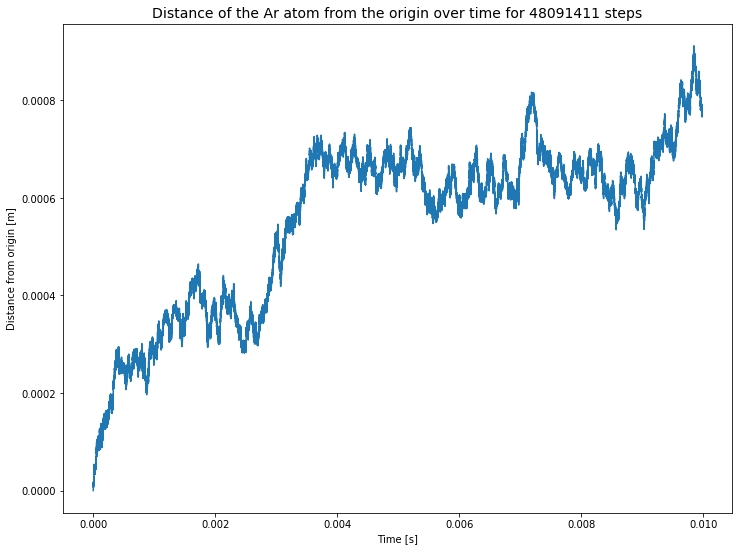

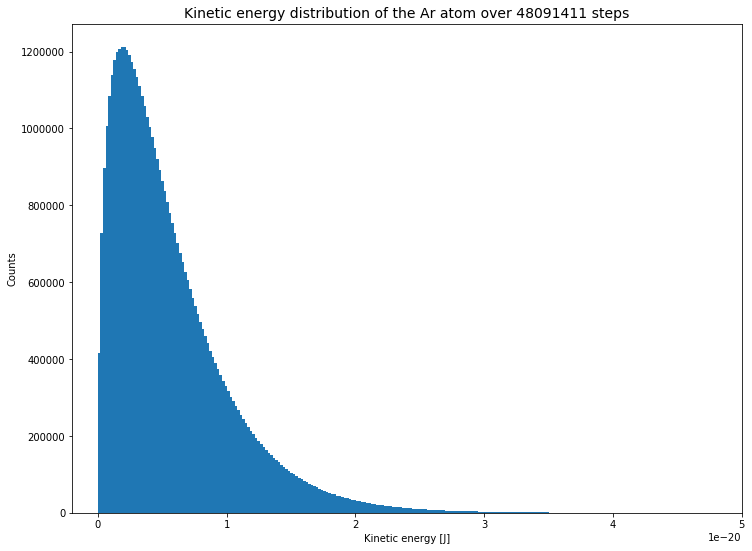

In [478]:
avg_cols_per_second = nsteps/t[-1]
print('Average number of collisions per second: %.4e' % avg_cols_per_second)

dist_from_origin = norm_batch(x)

#Plot the distance from the origin as a function of time
plt.figure(figsize=(12,9))
plt.plot(t, dist_from_origin)
plt.ylabel('Distance from origin [m]')
plt.xlabel('Time [s]')
plt.title('Distance of the Ar atom from the origin over time for %d steps' % nsteps, fontsize=14)

KE = 0.5*m*v**2

#Plot the kinetic energy distribution of the particle
plt.figure(figsize=(12,9))
plt.hist(KE, bins=400)
plt.xlabel('Kinetic energy [J]')
plt.ylabel('Counts')
plt.title('Kinetic energy distribution of the Ar atom over %d steps' % nsteps, fontsize=14)
plt.xlim(-0.2e-20, 5e-20)